In the following tutorial, we show how to fit the diffusion kurtosis model on
diffusion-weighted multi-shell datasets and how to estimate diffusion kurtosis
based statistics.

First, we import all relevant modules:

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import dipy.reconst.dki as dki
import dipy.reconst.msdki as msdki
import dipy.reconst.dti as dti
import dipy.reconst.dki_micro as dki_micro
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti
from dipy.segment.mask import median_otsu
from dipy.denoise.localpca import mppca
from dipy.denoise.gibbs import gibbs_removal

In this tutorial, let's load the CFIN rat data available at https://datadryad.org/stash/dataset/doi:10.5061/dryad.9bc43. Note, this data was acquired for a large number of b-values, however, we only selected the data for b-values = [0, 1, 2, 3, 4, 5] ms/um2 to represent the expected results for faster acquisition times (and also to make this tutorial faster to run).

In [3]:
data, affine = load_nifti("rat_sel.nii")
bvals, bvecs = read_bvals_bvecs("rat_sel.bval", "rat_sel.bvec")
gtab = gradient_table(bvals, bvecs)

Function ``load_nifti`` returns the data as a nibabel Nifti1Image object, and
``read_bvals_bvecs`` loads the arrays containing the information about the
b-values and b-vectors. These later arrays are converted to the GradientTable
object required for Dipy's data reconstruction.

Before fitting the data, we preform some data pre-processing. We first compute
a brain mask to avoid unnecessary calculations on the background of the image.

In [4]:
print("Generating mask")
maskdata, mask = median_otsu(data[:, :, :, 100], vol_idx=[0, 1], median_radius=4, numpass=4,
                             autocrop=False, dilate=None)

Generating mask


Text(0.5, 1.0, 'processed')

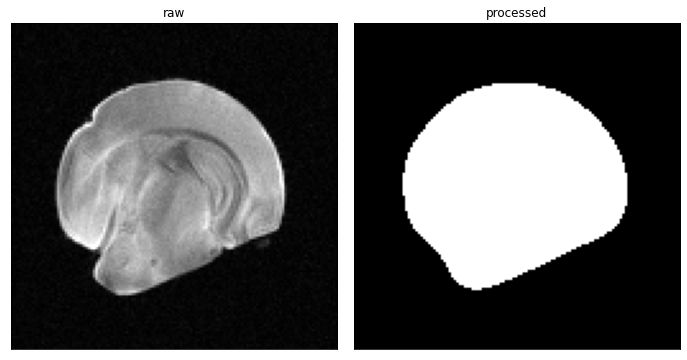

In [5]:
axial_slice = 10
vol = 100

fig1, ax = plt.subplots(1, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(data[:, :, axial_slice, vol].T, cmap='gray',
                  vmin=0, vmax=2000000, origin='lower')
ax.flat[0].set_title('raw')
ax.flat[1].imshow(mask[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=1, origin='lower')
ax.flat[1].set_title('processed')

Since the diffusion kurtosis models involves the estimation of a large number
of parameters [TaxCMW2015]_ and since the non-Gaussian components of the
diffusion signal are more sensitive to artefacts [NetoHe2012]_, it might be
favorable to suppress the effects of noise and artefacts before diffusion
kurtosis fitting. In this example the effects of noise are suppressed using the
Marcenko-Pastur PCA denoising algorithm (:ref:`example-denoise-mppca`) and
the Gibbs artefact suppression algorithm (:ref:`example-denoise-gibbs`). Due
to the dataset's large number of diffusion-weighted volumes, these algorithm
might take some hours to process.

In [30]:
print("Denoising")
den, sig = mppca(data, patch_radius=3, return_sigma=True)

Denoising


In [31]:
print("Removing Gibbs artifacts")
deng = gibbs_removal(den, slice_axis=2)

Removing Gibbs artifacts


Let's save the post-processed datasets in case we want to use this version of the data in other tools

In [6]:
#save_nifti('rat_den.nii', den, affine)
#save_nifti('rat_deng.nii', deng, affine)
den, affine = load_nifti('rat_den.nii')
deng, affine = load_nifti('rat_deng.nii')

Before carrying on with dki processing, I will just visually inspect the
quality of data and preprocessing step. In the figure below, I am ploting a
slice of the raw and denoised + gibbs suppressed data (upper panels).  Lower
left panel show the difference between raw and denoised data - this difference
map does not present anatomicaly information, indicating that PCA denoising
suppression noise with minimal low of anatomical information. Lower right map
shows the noise std estimate. Lower noise std values are underestimated in
background since noise in background appraoches a Rayleigh distribution.

Text(0.5, 1.0, 'diff')

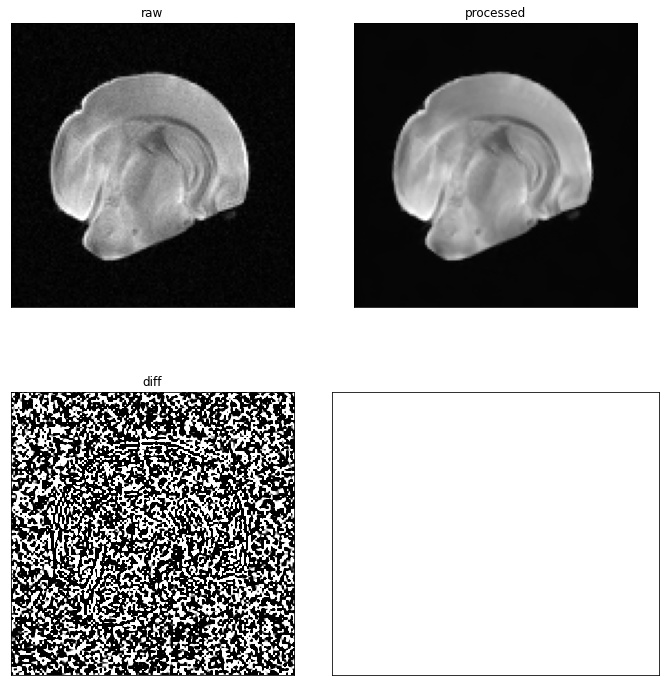

In [7]:
axial_slice = 10
vol = 100

fig1, ax = plt.subplots(2, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(data[:, :, axial_slice, vol].T, cmap='gray',
                  vmin=0, vmax=2000000, origin='lower')
ax.flat[0].set_title('raw')
ax.flat[1].imshow(deng[:, :, axial_slice, vol].T, cmap='gray',
                  vmin=0, vmax=2000000, origin='lower')
ax.flat[1].set_title('processed')
diff = den[:, :, axial_slice, vol].T - data[:, :, axial_slice, vol].T
ax.flat[2].imshow(diff, cmap='gray',
                  vmin=-10, vmax=10000, origin='lower')
ax.flat[2].set_title('diff')
#ax.flat[3].imshow(sig[:, :, axial_slice].T, cmap='gray',
#                  vmin=0, vmax=100000, origin='lower')
#ax.flat[3].set_title('noise std')


Now that we have loaded and pre-processed the data we can go forward
with DKI fitting. For this, the DKI model is first defined for the data's
GradientTable object by instantiating the DiffusionKurtosisModel object in the
following way:

In [8]:
dkimodel = dki.DiffusionKurtosisModel(gtab, fit_method="NLLS")

# DTI model for comparison
dtimodel = dti.TensorModel(gtab, fit_method="NLLS")

# For MSDKI MSK estimates
msdkimodel = msdki.MeanDiffusionKurtosisModel(gtab)

# For WMTI
dki_micro_model = dki_micro.KurtosisMicrostructureModel(gtab, fit_method="NLLS")

To fit the data using the defined model object, we call the ``fit`` function of
this object:

In [9]:
print("Fitting DKI model on raw data")
dkifitraw = dkimodel.fit(data, mask)

print("Fitting DKI model on denoised and de-Gibbs'ed data")
dkifit = dkimodel.fit(deng, mask)

print("Fitting DTI for reference")
dtifit = dtimodel.fit(deng, mask)

print("Fitting mean signal DKI on denoised and de-Gibbs'ed data")
msdkifit = msdkimodel.fit(deng, mask)

print("Fitting mean signal DKI on raw data")
msdkifitraw = msdkimodel.fit(data, mask)

Fitting DKI model on raw data


C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dti.py:1727: RuntimeWarning: divide by zero encountered in true_divide
  params[vox, 12:] = this_param[6:-1] / md2


Fitting DKI model on denoised and de-Gibbs'ed data
Fitting DTI for reference
Fitting mean signal DKI on denoised and de-Gibbs'ed data
Fitting mean signal DKI on raw data


The fit method creates a DiffusionKurtosisFit object, which contains all the
diffusion and kurtosis fitting parameters and other DKI attributes. For
instance, since the diffusion kurtosis model estimates the diffusion tensor,
all diffusion standard tensor statistics can be computed from the
DiffusionKurtosisFit instance. For example, we show below how to extract the
fractional anisotropy (FA), the mean diffusivity (MD), the axial diffusivity
(AD) and the radial diffusivity (RD) from the DiffusionKurtosisiFit instance.

In [10]:
print("Extracting DKI maps")
FAraw = dkifitraw.fa
MDraw = dkifitraw.md
ADraw = dkifitraw.ad
RDraw = dkifitraw.rd

FAden = dkifit.fa
MDden = dkifit.md
ADden = dkifit.ad
RDden = dkifit.rd

print("Extracting DTI maps for reference")
FAdti = dtifit.fa
MDdti = dtifit.md
ADdti = dtifit.ad
RDdti = dtifit.rd

Extracting DKI maps
Extracting DTI maps for reference


The DT based measures can be easily visualized using matplotlib. For example,
the FA, MD, AD, and RD obtained from the diffusion kurtosis model (upper
panels) and the tensor model (lower panels) are plotted for a selected axial
slice.

Visualizing results


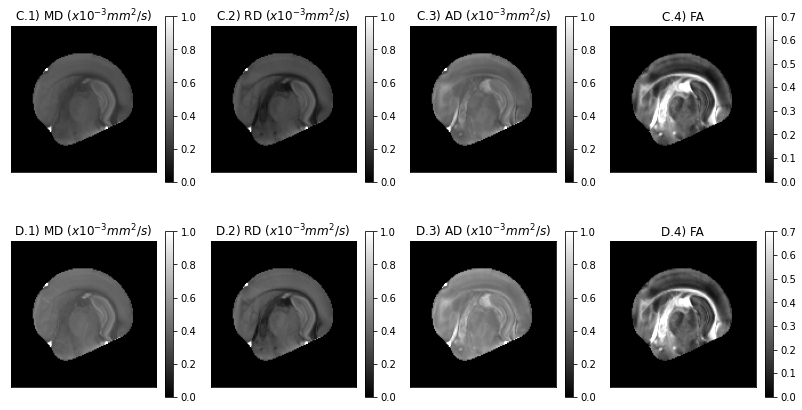

In [12]:
print("Visualizing results")
axial_slice = 10

sc = 1000  # diffusion scaling

fig2, ax = plt.subplots(2, 4, figsize=(14, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.1)

# Pre-processed DTI metrics
imdi = ax.flat[0].imshow(sc * MDdti[:, :, axial_slice].T, cmap='gray',
                         vmin=0, vmax=1, origin='lower')
ax.flat[0].set_title('C.1) MD ($x 10^{-3} mm^2/s$)')
ax.flat[1].imshow(sc * RDdti[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=1, origin='lower')
ax.flat[1].set_title('C.2) RD ($x 10^{-3} mm^2/s$)')
ax.flat[2].imshow(sc * ADdti[:, :, axial_slice].T, cmap='gray',
                   vmin=0, vmax=1, origin='lower')
ax.flat[2].set_title('C.3) AD ($x 10^{-3} mm^2/s$)')
imfa = ax.flat[3].imshow(FAdti[:, :, axial_slice].T, cmap='gray',
                         vmin=0, vmax=0.7, origin='lower')
ax.flat[3].set_title('C.4) FA')


# Pre-processed DKI metrics
ax.flat[4].imshow(sc * MDden[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=1, origin='lower')
ax.flat[4].set_title('D.1) MD ($x 10^{-3} mm^2/s$)')
ax.flat[5].imshow(sc * RDden[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=1, origin='lower')
ax.flat[5].set_title('D.2) RD ($x 10^{-3} mm^2/s$)')
ax.flat[6].imshow(sc * ADden[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=1, origin='lower')
ax.flat[6].set_title('D.3) AD ($x 10^{-3} mm^2/s$)')
ax.flat[7].imshow(FAden[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[7].set_title('D.4) FA')


# add colorbars
a = 0
for lin in range(0, 2):
    for i in range(0, 4):
        if i == 3:
            fig2.colorbar(imfa, ax=ax.flat[a])
        else:
            fig2.colorbar(imdi, ax=ax.flat[a])
        a += 1

plt.show()
fig2.savefig('Diffusion_Tensor_Metrics.png', bbox_inches='tight')


In addition to the standard diffusion statistics, the DiffusionKurtosisFit
instance can be used to estimate the non-Gaussian measures of mean kurtosis
(MK), the axial kurtosis (AK) and the radial kurtosis (RK).

Kurtosis measures are susceptible to high amplitude outliers. The impact of
high amplitude kurtosis outliers can be removed by introducing as an optional
input the extremes of the typical values of kurtosis. Here these are assumed to
be on the range between 0 and 3):

In [13]:
# Raw data reference for standard metrics
MKraw = dkifitraw.mk(0, 3)
AKraw = dkifitraw.ak(0, 3)
RKraw = dkifitraw.rk(0, 3)

# DKI standard metrics
MKden = dkifit.mk(0, 3)
AKden = dkifit.ak(0, 3)
RKden = dkifit.rk(0, 3)

# DKI KFA and MKT
MKTden = dkifit.mkt(0, 3)
KFAden = dkifit.kfa
MKTraw = dkifitraw.mkt(0, 3)
KFAraw = dkifitraw.kfa

# MSDKI MSK
MSKden = msdkifit.msk
MSKraw = msdkifitraw.msk

C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dki.py:2421: RuntimeWarning: invalid value encountered in add
  Wre = Wre + multiplyB * kt[..., ind_ele[key]]
C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dki.py:759: RuntimeWarning: invalid value encountered in multiply
  _F1m(evals[..., 2], evals[..., 1], evals[..., 0]) * Wzzzz + \
C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dki.py:1012: RuntimeWarning: invalid value encountered in multiply
  _G1m(evals[..., 0], evals[..., 2], evals[..., 1]) * Wzzzz + \
C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dki.py:1379: RuntimeWarning: invalid value encountered in add
  MKT = 1/5 * (dki_params[..., 12] + dki_params[..., 13] +
C:\Users\rafae\anaconda3\envs\dipy_source\lib\site-packages\dipy\reconst\dki.py:1444: RuntimeWarning: invalid value encountered in add
  W = 1.0/5.0 * (Wxxxx + Wyyyy + Wzzzz + 2*Wxxyy + 2*Wxxzz + 2*Wyyzz)
C:\Users\ra

Now we are ready to plot the kurtosis standard measures using matplotlib:

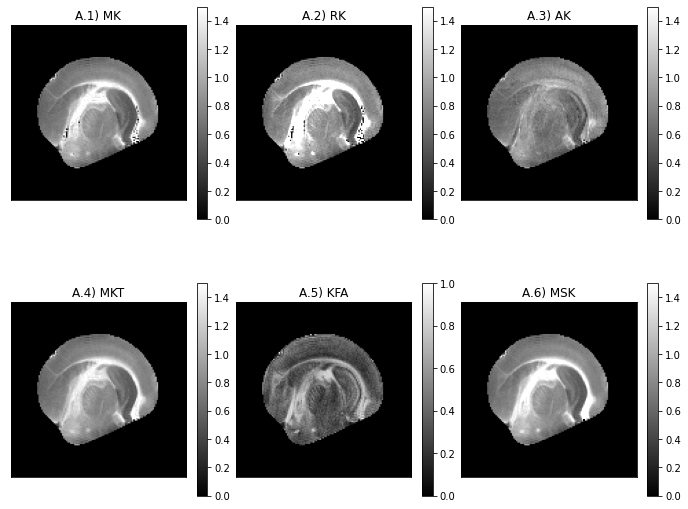

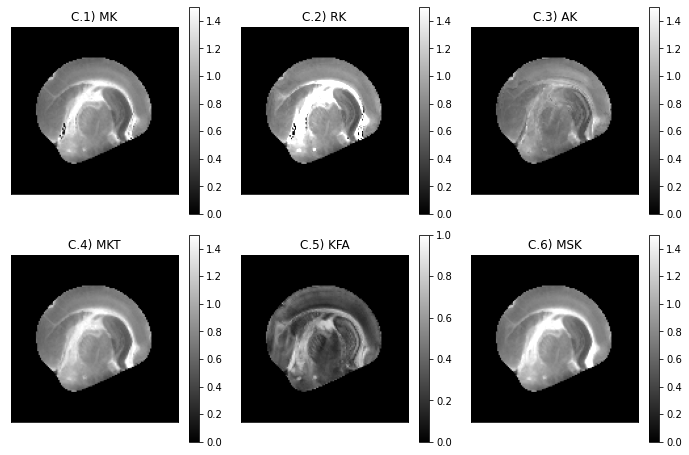

In [14]:
axial_slice = 10

fig3, ax = plt.subplots(2, 3, figsize=(12, 9),
                        subplot_kw={'xticks': [], 'yticks': []})

fig3.subplots_adjust(hspace=0.3, wspace=0.03)

imkurt = ax.flat[0].imshow(MKraw[:, :, axial_slice].T, cmap='gray',
                           vmin=0, vmax=1.5, origin='lower')
ax.flat[0].set_title('A.1) MK')

ax.flat[1].imshow(RKraw[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('A.2) RK')

ax.flat[2].imshow(AKraw[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[2].set_title('A.3) AK')



ax.flat[3].imshow(MKTraw[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[3].set_title('A.4) MKT')
imkfa = ax.flat[4].imshow(KFAraw[:, :, axial_slice].T, cmap='gray',
                          vmin=0, vmax=1, origin='lower')
ax.flat[4].set_title('A.5) KFA')

ax.flat[5].imshow(MSKraw[:, :, axial_slice].T, cmap='gray', vmin=0,
                  vmax=1.5, origin='lower')
ax.flat[5].set_title('A.6) MSK')

# add colorbars
a = 0
for lin in range(0, 3):
    for i in range(0, 2):
        if a == 4:
            fig3.colorbar(imkfa, ax=ax.flat[a])
        else:
            fig3.colorbar(imkurt, ax=ax.flat[a])
        a += 1

plt.show()
fig3.savefig('Kurtosis_Metrics_raw.png', bbox_inches='tight')

# Denoised data

axial_slice = 10

fig3, ax = plt.subplots(2, 3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

fig3.subplots_adjust(hspace=0.1, wspace=0.1)

imkurt = ax.flat[0].imshow(MKden[:, :, axial_slice].T, cmap='gray',
                           vmin=0, vmax=1.5, origin='lower')
ax.flat[0].set_title('C.1) MK')

ax.flat[1].imshow(RKden[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('C.2) RK')


ax.flat[2].imshow(AKden[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[2].set_title('C.3) AK')



ax.flat[3].imshow(MKTden[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[3].set_title('C.4) MKT')

imkfa = ax.flat[4].imshow(KFAden[:, :, axial_slice].T, cmap='gray',
                          vmin=0, vmax=1, origin='lower')
ax.flat[4].set_title('C.5) KFA')

ax.flat[5].imshow(MSKden[:, :, axial_slice].T, cmap='gray', vmin=0,
                  vmax=1.5, origin='lower')
ax.flat[5].set_title('C.6) MSK')


# add colorbars
a = 0
for lin in range(0, 3):
    for i in range(0, 2):
        if a == 4:
            fig3.colorbar(imkfa, ax=ax.flat[a])
        else:
            fig3.colorbar(imkurt, ax=ax.flat[a])
        a += 1

plt.show()
fig3.savefig('Kurtosis_Metrics.png', bbox_inches='tight')

Visualizing final plots


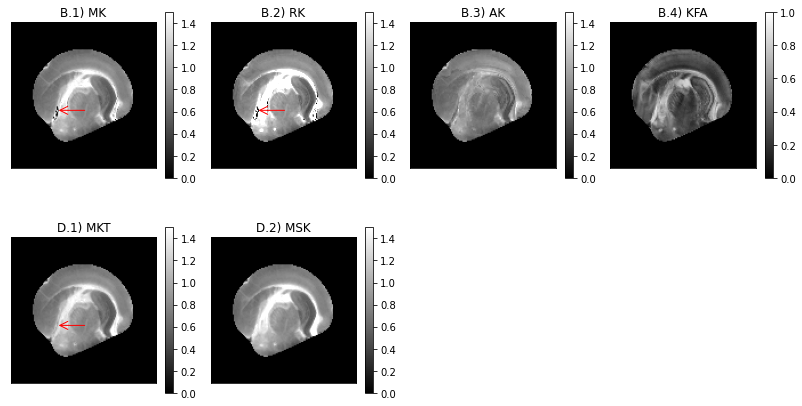

In [18]:
# Produce Final Figures
print("Visualizing final plots")
axial_slice = 10

fig, ax = plt.subplots(2, 4, figsize=(14, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.1)

imkurt = ax.flat[0].imshow(MKden[:, :, axial_slice].T, cmap='gray',
                           vmin=0, vmax=1.5, origin='lower')
ax.flat[0].set_title('B.1) MK')
ax.flat[0].annotate('', fontsize=20, xy=(40, 50),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

ax.flat[1].imshow(RKden[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('B.2) RK')
ax.flat[1].annotate('', fontsize=20, xy=(40, 50),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))


ax.flat[2].imshow(AKden[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[2].set_title('B.3) AK')



ax.flat[4].imshow(MKTden[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[4].set_title('D.1) MKT')
ax.flat[4].annotate('', fontsize=20, xy=(40, 50),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

imkfa = ax.flat[3].imshow(KFAden[:, :, axial_slice].T, cmap='gray',
                          vmin=0, vmax=1, origin='lower')
ax.flat[3].set_title('B.4) KFA')

ax.flat[5].imshow(MSKden[:, :, axial_slice].T, cmap='gray', vmin=0,
                  vmax=1.5, origin='lower')
ax.flat[5].set_title('D.2) MSK')


# add colorbars
a = 0
for lin in range(0, 3):
    for i in range(0, 2):
        if a == 3:
            fig3.colorbar(imkfa, ax=ax.flat[a])
        else:
            fig3.colorbar(imkurt, ax=ax.flat[a])
        a += 1
ax.flat[6].axis('off')
ax.flat[7].axis('off')

plt.show()
fig.savefig('Human_dki.png', bbox_inches='tight')

The non-Gaussian behaviour of the diffusion signal is expected to be higher
when tissue water is confined in multiple compartments. Therefore, MK is
higher in white matter due to the presence of myelin sheath that highly
compartmentalize different tissue compartments. These non-Gaussian effects are
expected to be more pronounced in prependicularly to white matter fibers and
thus the RK map presents higher amplitudes than the AK map.

The mean of the kurtosis tensor (MKT) produces
similar maps than the standard mean kurtosis (MK). On the other hand,
the kurtosis fractional anisotropy (KFA) maps shows that the kurtosis tensor
have different degrees of anisotropy than the FA measures from the diffusion
tensor.

# Microstructural models from DKI and MSDKI


DKI can also be used to derive concrete biophysical parameters by applying
microstructural models to DT and KT estimated from DKI

Before fitting this microstructural model, it is useful to indicate the
regions in which this model provides meaningful information (i.e. voxels of
well-aligned fibers). Following Fieremans et al. (2011), a simple way
to select this region is to generate a well-aligned fiber mask based on the
values of diffusion sphericity, planarity and linearity. Here we will follow
these selection criteria for a better comparison of our figures with the
original article published by Fieremans et al. (2011). Nevertheless,
it is important to note that voxels with well-aligned fibers can be selected
based on other approaches such as using predefined regions of interest.

In [66]:
# Initialize well aligned mask with ones
well_aligned_mask = np.ones(data.shape[:-1], dtype='bool')

# Diffusion coefficient of linearity (cl) has to be larger than 0.2, thus
# we exclude voxels with cl < 0.2.
cl = dkifit.linearity.copy()
well_aligned_mask[cl < 0.2] = False

# Diffusion coefficient of planarity (cp) has to be lower than 0.5, thus
# we exclude voxels with cp > 0.5.
cp = dkifit.planarity.copy()
well_aligned_mask[cp > 0.5] = False

# Diffusion coefficient of sphericity (cs) has to be lower than 0.5, thus
# we exclude voxels with cs > 0.5.
cs = dkifit.sphericity.copy()
well_aligned_mask[cs > 0.5] = False

# Removing nan associated with background voxels
well_aligned_mask[np.isnan(cl)] = False
well_aligned_mask[np.isnan(cp)] = False
well_aligned_mask[np.isnan(cs)] = False

Text(0.5, 1.0, 'processed')

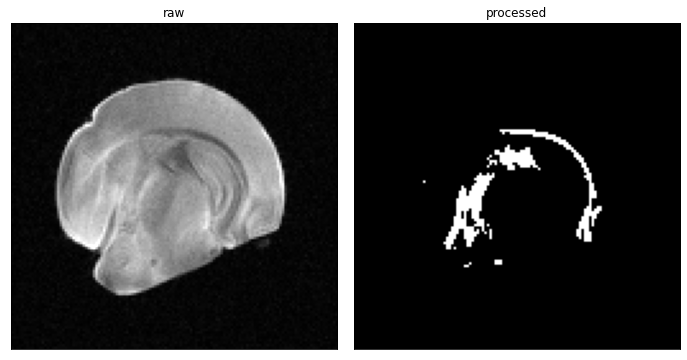

In [68]:
axial_slice = 10
vol = 100

fig1, ax = plt.subplots(1, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(data[:, :, axial_slice, vol].T, cmap='gray',
                  vmin=0, vmax=2000000, origin='lower')
ax.flat[0].set_title('raw')
ax.flat[1].imshow(well_aligned_mask[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=1, origin='lower')
ax.flat[1].set_title('processed')

Analogous to DKI, the data fit can be done by calling the ``fit`` function of
the model's object as follows:

In [69]:
dki_micro_fit = dki_micro_model.fit(deng, mask=well_aligned_mask)

The KurtosisMicrostructureFit object created by this ``fit`` function can then
be used to extract model parameters such as the axonal water fraction and
diffusion hindered tortuosity:

In [70]:
AWF = dki_micro_fit.awf
TORT = dki_micro_fit.tortuosity

As showed by [NetoHe2019], MSDKI captures the same information than the
spherical mean technique (SMT) microstructural models [Kaden2016b]. In this
way, the SMT model parameters can be directly computed from MSDKI. For
instance, the axonal volume fraction (AWF) and the intrisic diffusivity (di)
and the microscopic anisotropy of the SMT 2-compartmental model [NetoHe2019]
can be extracted using the following lines of code:

In [71]:
F = msdkifit.smt2f
DI = msdkifit.smt2di

Below we plot the metrics from the DKI and MSDKI-based models. Note that the
WMTI parameters extracted from the well aligned WM region of interest are
plotted on top of the mean signal kurtosis maps in panels A.1 and B.1, while
the axonal volume fraction (AWF) and the intrisic diffusivity (di) are plotted
on panels C and D.

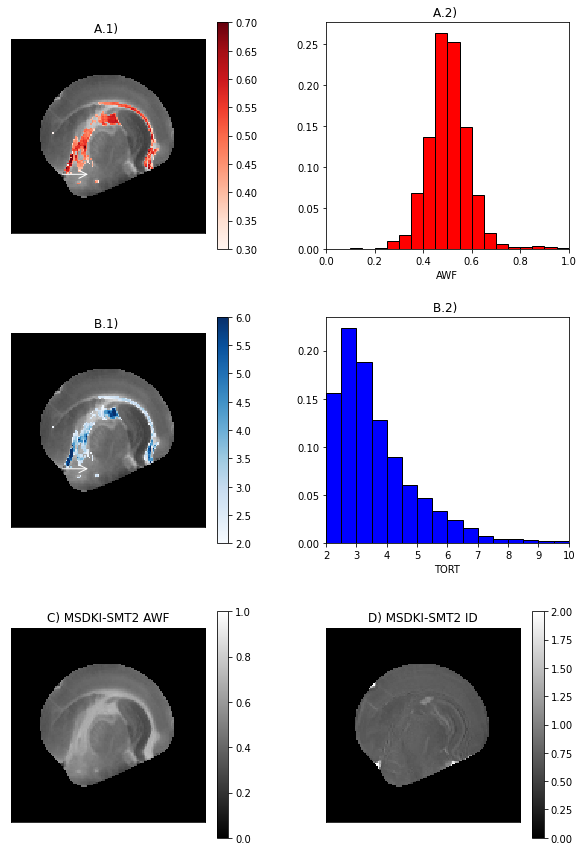

In [72]:
AWF0 = AWF.copy()
TORT0 = TORT.copy()

AWF[AWF0 == 0] = np.nan
TORT[TORT0 == 0] = np.nan

axial_slice = 10

fig4, axs = plt.subplots(3, 2, figsize=(10, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

fig4.subplots_adjust(hspace=0.3, wspace=0.3)

axs.flat[0].imshow(MSKden[:, :, axial_slice].T, cmap=plt.cm.gray,
                   interpolation='nearest', origin='lower', vmin=0, vmax=2)
im0 = axs.flat[0].imshow(AWF[:, :, axial_slice].T, cmap=plt.cm.Reds, alpha=1,
                         vmin=0.3, vmax=0.7, interpolation='nearest',
                         origin='lower')
axs.flat[0].annotate('', fontsize=20, xy=(32, 38),
                     xycoords='data', xytext=(30, 0),
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle="<-",
                                     color=[1, 1, 1]))
axs.flat[0].set_title('A.1) ')
fig4.colorbar(im0, ax=axs.flat[0])

axs.flat[2].imshow(MSKden[:, :, axial_slice].T, cmap=plt.cm.gray,
                   interpolation='nearest', origin='lower', vmin=0, vmax=2)
im1 = axs.flat[2].imshow(TORT[:, :, axial_slice].T, cmap=plt.cm.Blues, alpha=1,
                         vmin=2, vmax=6, interpolation='nearest',
                         origin='lower')
axs.flat[2].annotate('', fontsize=20, xy=(32, 38),
                     xycoords='data', xytext=(30, 0),
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle="<-",
                                     color=[1, 1, 1]))
axs.flat[2].set_title('B.1) ')
fig4.colorbar(im1, ax=axs.flat[2])

# Ploting histogram
x = AWF0[well_aligned_mask].flatten()
x = x[~np.isnan(x)]
x = x[x > 0]
N, bins = np.histogram(x, bins=20, range=(0, 1))
N = N / N.sum()
axs.flat[1].clear()
axs.flat[1].bar(bins[:-1] + 0.025, N, width=0.05,
                edgecolor=[0, 0, 0], color=[1, 0, 0])
axs.flat[1].set_xlabel('AWF')
axs.flat[1].set_title('A.2) ')
axs.flat[1].set_xlim(0, 1)

x = TORT0[well_aligned_mask].flatten()
x = x[~np.isnan(x)]
x = x[x > 0]
N, bins = np.histogram(x, bins=20, range=(0, 10))
N = N / N.sum()
axs.flat[3].clear()
axs.flat[3].bar(bins[:-1] + 0.25, N, width=0.5,
                edgecolor=[0, 0, 0], color=[0, 0, 1])
axs.flat[3].set_xlabel('TORT')
axs.flat[3].set_title('B.2) ')
axs.flat[3].set_xlim(2, 10)


im2 = axs.flat[4].imshow(F[:, :, axial_slice].T, cmap=plt.cm.gray,
                         interpolation='nearest', origin='lower',
                         vmin=0, vmax=1)
axs.flat[4].set_title('C) MSDKI-SMT2 AWF')

im3 = axs.flat[5].imshow(DI[:, :, axial_slice].T * 1000, cmap=plt.cm.gray,
                         interpolation='nearest', origin='lower',
                         vmin=0, vmax=2)
axs.flat[5].set_title('D) MSDKI-SMT2 ID')

fig4.colorbar(im2, ax=axs.flat[4])
fig4.colorbar(im3, ax=axs.flat[5])

fig4.savefig('MSDKI_Metrics.png', bbox_inches='tight')
plt.show()

Axonal water fraction (left panel) and tortuosity (right panel) values of well-aligned fiber regions overlaid on a top of a mean kurtosis all-brain image.

References
----------

.. [Fierem2011] Fieremans E, Jensen JH, Helpern JA (2011). White matter
                characterization with diffusion kurtosis imaging. NeuroImage
                58: 177-188
.. [Hansen2016] Hansen, B, Jespersen, SN (2016). Data for evaluation of fast
                kurtosis strategies, b-value optimization and exploration of
                diffusion MRI contrast. Scientific Data 3: 160072
                doi:10.1038/sdata.2016.72